## 중간층의 활성화 시각화하기
> 중간층의 활성화 시각화는 어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성맵을 그리는 것이다(**활성화**라고도 부른다). 이 방법은 네트워크에 의해 학습된 필터들이 어떻게 입력을 분해하는지 보여준다. 너비, 높이, 깊이(채널) 3개의 차원에 대해 특성 맵을 시각화 하는 것이 좋다.
### 모델 로드하기

In [1]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5',compile = False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### 개별 이미지 전처리 하기

In [2]:
img_path = './datasets/train/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4D텐서로 변경한다.
img_tensor /= 255. # 모델이 훈련될 때 입력에 전처리 방식을 동일하게 사용한다.

print(img_tensor.shape) # 이미지 텐서의 크기는 (1, 150, 150, 3)이다.

(1, 150, 150, 3)


### 테스트 사진 출력하기

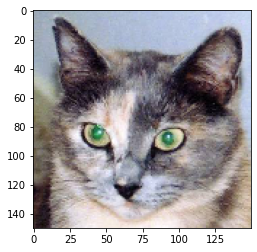

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

#### 확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링층의 활성화를 출력하는 케라스 모델 만들기

### 입력텐서와 출력텐서의 리스트로 모델 객체 만들기

In [5]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개의 출력을 추출한다.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 입력에 대해 8개 층의 출력을 반환하는 모델

In [7]:
activations = activation_model.predict(img_tensor) # 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환한다.

In [8]:
first_layer_activation = activations[0]

In [9]:
print(first_layer_activation.shape)

(1, 148, 148, 32)


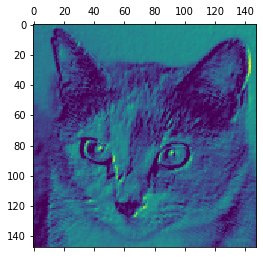

In [10]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 19 ], cmap='viridis')

### 16번째 채널 시각화하기

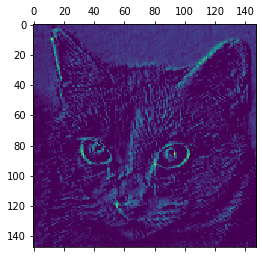

In [11]:
plt.matshow(first_layer_activation[0, : , :, 15], cmap='viridis')

### 중간층의 모든 활성화에 있는 채널 시각화하기

<ipython-input-19-e9416c826a4a>:17: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


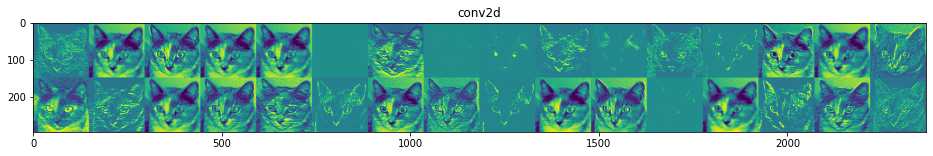

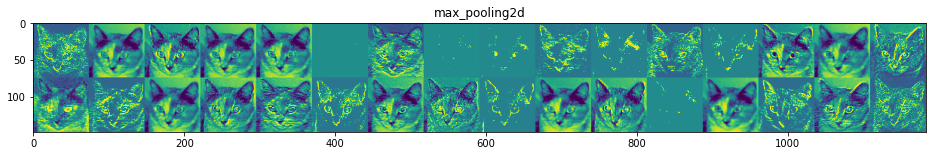

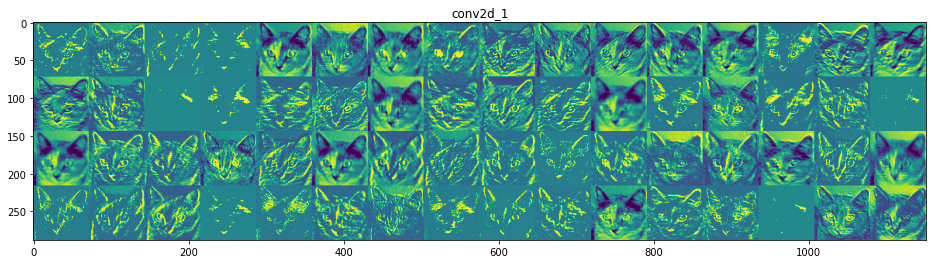

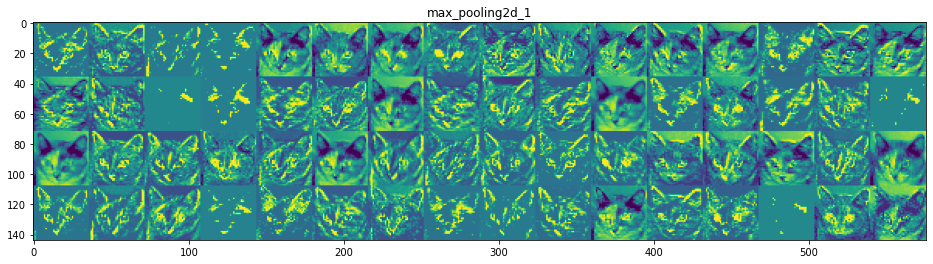

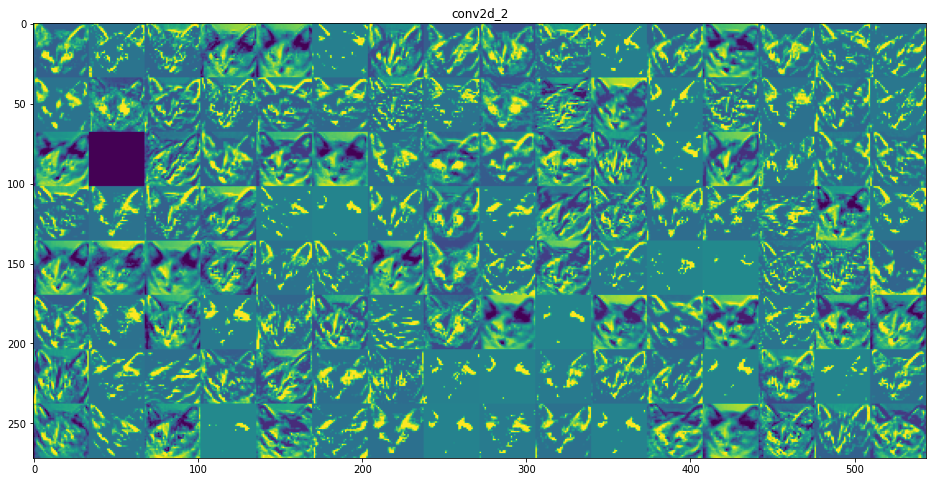

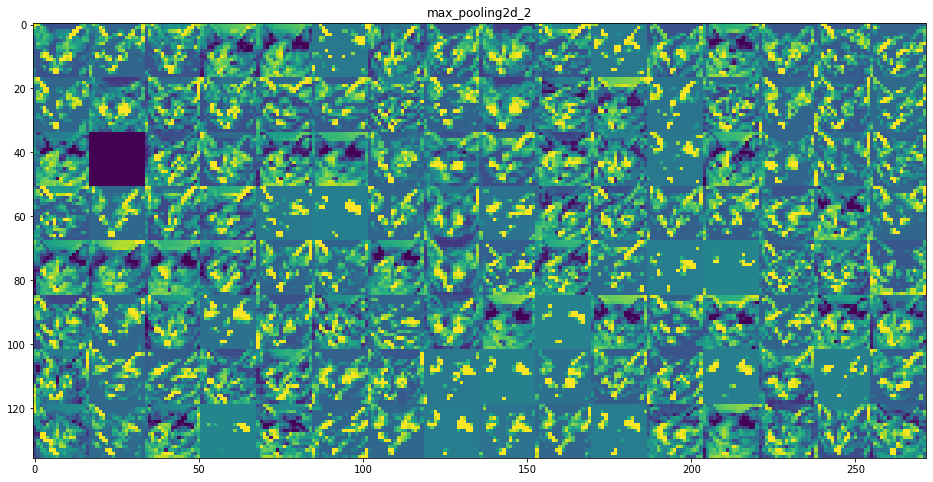

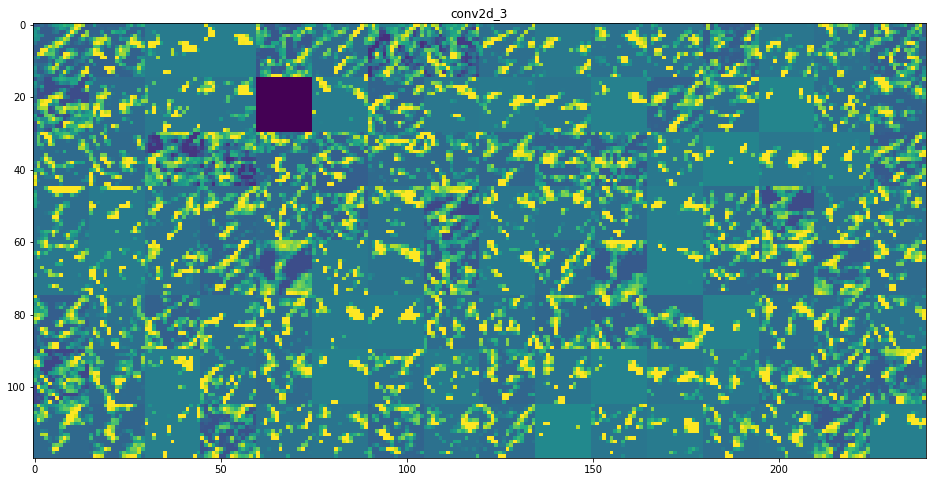

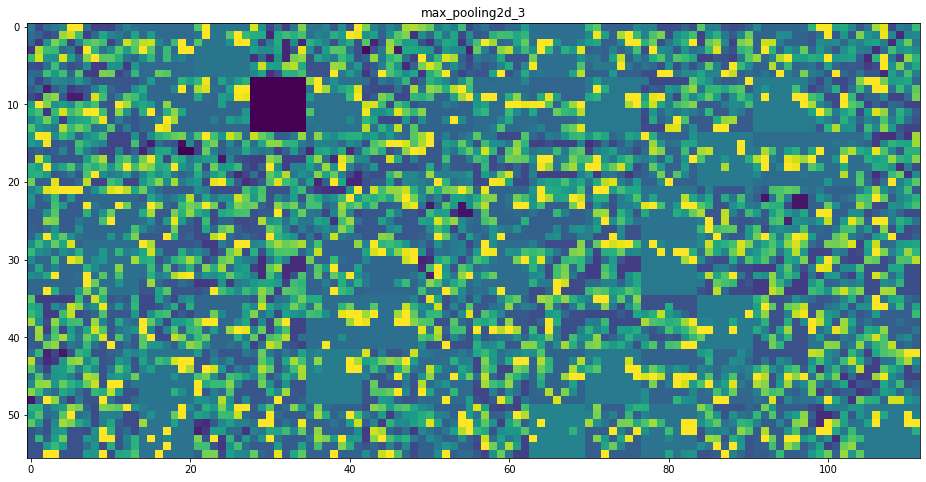

In [19]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col+1) * size, row*size : (row+1)*size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

* 첫 번재 층은 여러 종류의 에지 감지기를 모아 놓은 것 같다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지된다.
*상위층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워 진다. '고양이 귀'와 '고양이 눈'처럼 고수준 개념을 인코딩하기 시작한다. 상위층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가한다.
* 비어 있는 활성화가 층이 깊어짐에 따라 늘어난다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화 되었지만 층을 올라가면서 비는 필터가 생긴다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미한다.